## Understanding the Geometry of MAD with Interative Plot Widget

In [1]:
import numpy as np
from math import pi
from test_functions1D import MultiMinimaFunc_numpy, Sinc_numpy, Sin_numpy, MultiMinimaAbsFunc_numpy, DiscontinuousFunc_numpy
import matplotlib.pyplot as plt
from ipywidgets import FloatText, Button, Output, VBox, HTML, HBox, Dropdown
from scipy.optimize import differential_evolution
from matplotlib.ticker import MaxNLocator


# h is the function to be minizer over z for parameters f, T, and x
def h(z, h_parameters):
    f, T, x = h_parameters # Unpack the parameters (f = selected_function, T = fixed_T)
    return f(z) + (1 / (2 * T)) * (z - x)**2

class HJMoreauAdaptiveDescentVisualizer:
    def __init__(self):
        # Initialize global variables for function and plotting range
        self.selected_function = MultiMinimaFunc_numpy  # Default function
        self.intervalx_a, self.intervalx_b = -30.0, 30.0
        self.global_min_x, self.global_min_f = -1.51035, -4.76275
        self.value_T = 95
        self.gamma = 1.89777  # Default gamma for MultiMinima

        # Initialize widgets (replacing sliders with FloatText input fields)
        self.x_0_input = FloatText(value=(self.intervalx_b-self.intervalx_a)/6+self.intervalx_a, description='x_0:')
        self.fixed_T_input = FloatText(value=self.value_T, description='Fixed time, T:')
        self.plot_output = Output()
        self.error_plot_output = Output()
        self.t_threshold_display = HTML()
        self.alpha_input = FloatText(value=0.1, description='Alpha:')
        self.momentum_input = FloatText(value=0.5, description='Momentum:')
        self.function_dropdown = Dropdown(options=['MultiMinima', 'Sinc', 'Sin', 'MultiMinimaAbsFunc', 'DiscontinuousFunc'], value='MultiMinima', description='Function:')

        # Create buttons
        self.iterate_button = Button(description='Iterate and Plot', button_style='info')
        self.run_100_iterations_button = Button(description='Run 100 Iterations', button_style='warning')
        self.reset_button = Button(description='Reset', button_style='success')

        # Bind events
        self.function_dropdown.observe(self.function_dropdown_update, names='value')
        self.x_0_input.observe(self.x_0_input_update, names='value')
        self.alpha_input.observe(self.alpha_input_update, names='value')
        self.momentum_input.observe(self.momentum_input_update, names='value')
        self.fixed_T_input.observe(self.fixed_T_input_update, names='value')
        self.iterate_button.on_click(self.run_iteration)
        self.reset_button.on_click(self.reset)
        self.run_100_iterations_button.on_click(self.run_100_iterations)

        # Display layout
        self.display_layout()

        # Initial t_threshold update
        self.update_t_threshold_display()

        # Initialize Error:
        self.initialize_history()

        # Update Moreau Envelope
        self.x_values = np.linspace(self.intervalx_a, self.intervalx_b, 500)
        self.update_moreau_envelope()

        self.update_plots()

    def initialize_history(self):
        # Initialize x_k for x_0
        self.k = 0
        self.x_k = self.x_0_input.value
        self.acc_x_k = self.x_0_input.value
        self.acc_x_k_minus_1 = self.x_0_input.value

        # Compute f(x_0)
        f_k = self.selected_function(self.x_k)

        # Store the initial function value and initial errors
        self.acc_f_k_hist = [f_k]
        self.acc_error_k_hist = [np.linalg.norm(self.x_k - self.global_min_x)]

        self.f_k_hist = [f_k]
        self.error_k_hist = [np.linalg.norm(self.x_k - self.global_min_x)]

        self.f_k_hist_HJ = [f_k]
        self.error_k_hist_HJ = [np.linalg.norm(self.x_k - self.global_min_x)]


        _, grad_k = self.gradient_descent(self.x_k)
        self.gk_hist = [(self.x_k,grad_k)]

    def display_layout(self):
        note = HTML("""<p>Select a function from the dropdown and adjust the inputs to modify the values of fixed time <strong>T</strong>, <strong>x_k</strong>, and Step Size <strong>&alpha;</strong>.</p>""")
        display(VBox([
            HTML('<h2>HJ Moreau Adaptive Descent Visualizer</h2>'),
            note,
            self.function_dropdown,
            HBox([self.x_0_input, self.fixed_T_input, self.alpha_input, self.momentum_input]),
            self.t_threshold_display,  # Display for t_threshold
            HBox([self.iterate_button, self.run_100_iterations_button, self.reset_button]),  # Added plot button to the layout
            self.plot_output,
            self.error_plot_output
        ]))

    def reset(self, _=None):
        self.initialize_history()
        self.update_moreau_envelope()
        self.update_plots()

    def x_0_input_update(self, _):
        self.initialize_history()
        self.update_t_threshold_display()
        self.update_plots()

    def run_iteration(self, button):
        """Run 100 iterations and update the plot."""
        self.update_x_k(button)
        self.update_plots()

    def function_dropdown_update(self, change):
        self.update_function(change)
        self.initialize_history()
        self.update_t_threshold_display()
        self.update_moreau_envelope()
        self.update_plots()

    def alpha_input_update(self, _):
        self.initialize_history()
        self.update_plots()

    def momentum_input_update(self, _):
        self.initialize_history()
        self.update_plots()

    def fixed_T_input_update(self, _):
        self.initialize_history()
        self.update_moreau_envelope()
        self.update_plots()

    def run_100_iterations(self, button):
        """Run 100 iterations and update the plot."""
        self.initialize_history()
        for _ in range(100):
            self.update_x_k(button)  # Use the existing method to update x_k and history
        self.update_plots()  # Finally, update the plots after iterations

    def update_t_threshold_display(self):
        """Update the display for the t_threshold and compute its value."""

        # Create the HTML string
        html_content = """
        <div style="border: 1px solid black; padding: 10px; border-radius: 5px; margin-top: 10px;">
        <h4 style="margin: 0;">Time Threshold <i>(Theoretical Lower Bound on Initial Time Steps for Convergence)</i></h4>
        <div style="font-family: Times New Roman, serif; font-size: 14px;">
            <p><strong>t<sub>threshold</sub> = {}
        """

        # Calculate t_threshold
        if self.gamma is not None:
            t_threshold = (np.linalg.norm(self.global_min_x - self.x_0_input.value)**2) / (2 * self.gamma)
            # Use str.format to insert the calculated value into html_content
            self.t_threshold_display.value = html_content.format(f"""
                {t_threshold:.2f}, where</strong>:</p><p style="margin-left: 20px;">
                T ≥ ||x* - x<sub>k</sub>||<sup>2</sup> / (2γ) = t<sub>threshold</sub> > 0
                </p>
                </div>
                """)
        else:
            # If self.gamma is None, modify html_content to show 'UnDefined'
            self.t_threshold_display.value = html_content.format('UnDefined</p></div>')
            return

    def update_function(self, change):
        """Update the function and range based on dropdown selection."""
        if change['new'] == 'Sinc':
            self.min_T, self.max_T = 1, 1000
            self.selected_function = Sinc_numpy
            self.intervalx_a, self.intervalx_b = -20, 20
            self.gamma = 0.1259
        elif change['new'] == 'Sin':
            self.min_T, self.max_T = 1, 500
            self.selected_function = Sin_numpy
            self.intervalx_a, self.intervalx_b = -3.5 * pi, 2.5 * pi
            self.gamma = None
        elif change['new'] == 'MultiMinimaAbsFunc':
            self.min_T, self.max_T = 0.1, 100
            self.selected_function = MultiMinimaAbsFunc_numpy
            self.intervalx_a, self.intervalx_b = -15, 15
            self.gamma = 1.43457
        elif change['new'] == 'DiscontinuousFunc':
            self.min_T, self.max_T = 0.1, 100
            self.selected_function = DiscontinuousFunc_numpy
            self.intervalx_a, self.intervalx_b = -20, 15
            self.gamma = 7
        else:  # 'MultiMinima'
            self.min_T, self.max_T = 0.1, 100
            self.selected_function = MultiMinimaFunc_numpy
            self.intervalx_a, self.intervalx_b = -30, 30
            self.gamma = 1.89777

        # Compute global minimum
        result = differential_evolution(self.selected_function, [(self.intervalx_a, self.intervalx_b)])
        self.global_min_x = result.x
        self.global_min_f = result.fun

        # Update inputs and plot
        self.x_0_input.value = (self.intervalx_a + self.intervalx_b) / 2
        self.fixed_T_input.value = (self.min_T + self.max_T) / 2

    def scipy_compute_prox_and_grad(self, x_k):
        """
        Compute the prox and gradient using Scipy's differential evolution method.

        """
        fixed_T = self.fixed_T_input.value

        # Find the global minimum using the differential evolution method
        hk_parameters = (self.selected_function, fixed_T, x_k)
        result = differential_evolution(h, [(self.intervalx_a, self.intervalx_b)], args=(hk_parameters,))

        # Compute the correct gradient and prox
        prox_k = result.x[0]
        grad_k = (x_k - prox_k) / fixed_T

        return prox_k, grad_k

    
    def HJ_compute_prox_and_grad(self, x_k, delta=0.1, int_samples=1000, eps=1e-14):
        """
        Compute the prox and gradient using the Hamilton-Jacobi (HJ) method.
        """
        fixed_T = self.fixed_T_input.value

        standard_dev = np.sqrt(delta * fixed_T)
        y = standard_dev * np.random.randn(int_samples) + x_k

        exp_term = np.exp(-self.selected_function(y) / delta)
        v_delta = np.mean(exp_term) + eps

        numerator = np.mean(y * exp_term)

        grad_k = (x_k - numerator / v_delta)
        prox_k = numerator / v_delta

        return prox_k, grad_k


    def gradient_descent(self, x_k, method="HJ"):
        """
        Perform standard gradient descent.

        Args:
            x_k: Current iterate value.
            method: Descent method ('HJ' or 'Scipy').

        Returns:
            x_k_plus_1: Updated iterate after gradient descent.
            grad_k: Gradient at x_k.
        """
        alpha = self.alpha_input.value

        if method == "HJ":
            prox_k, grad_k = self.HJ_compute_prox_and_grad(x_k)
        elif method == "scipy":
            prox_k, grad_k = self.scipy_compute_prox_and_grad(x_k)
        else:
            raise ValueError(f"Unknown method {method}")

        # Perform gradient descent update
        x_k_plus_1 = x_k - alpha * (x_k-prox_k)

        return x_k_plus_1, grad_k
    
    def accelerated_gradient_descent(self, momentum, method="HJ"):
        """
        Perform accelerated gradient descent.
        """
        if self.k > 1:
            y_k = self.acc_x_k + momentum * (self.acc_x_k - self.acc_x_k_minus_1)
            acc_x_k_plus_1, grad_k = self.gradient_descent(y_k, method=method)
        else:
            acc_x_k_plus_1, grad_k = self.gradient_descent(self.x_k, method=method)

        return acc_x_k_plus_1, grad_k

    def update_x_k(self, button):
        """
        Update x_k and x_k_accelerated based on gradient descent and acceleration.

        Args:
            button: The trigger event (e.g., UI button click).
        """
        momentum = self.momentum_input.value
        self.k += 1

        # Perform gradient descent for both methods
        x_k_plus_1_HJ, _ = self.gradient_descent(self.x_k, method="scipy")
        x_k_plus_1_scipy, grad_k_scipy = self.gradient_descent(self.x_k)

        # Approximated Gradient
        self.gk_hist.append((self.x_k, grad_k_scipy))

        # Update x_k for both methods
        self.x_k = x_k_plus_1_scipy
        self.x_k_HJ = x_k_plus_1_HJ

        # Perform accelerated gradient descent
        acc_x_k_plus_1,grad_k = self.accelerated_gradient_descent(momentum)

        # Update accelerated x_k and x_k_minus
        self.acc_x_k_minus_1 = self.acc_x_k
        self.acc_x_k = acc_x_k_plus_1

        # Record function values and errors
        # Calculate the function value and error for the accelerated method
        f_k_accelerated = self.selected_function(self.acc_x_k)
        self.acc_f_k_hist.append(f_k_accelerated)
        self.acc_error_k_hist.append(np.linalg.norm(self.acc_x_k - self.global_min_x))

        # Calculate the function value and error for the original method
        f_k_HJ = self.selected_function(self.x_k_HJ)
        self.f_k_hist_HJ.append(f_k_HJ)
        self.error_k_hist_HJ.append(np.linalg.norm(self.x_k_HJ - self.global_min_x))

        # Calculate the function value and error for the original method
        f_k = self.selected_function(self.x_k)
        self.f_k_hist.append(f_k)
        self.error_k_hist.append(np.linalg.norm(self.x_k - self.global_min_x))


    def update_plots(self):
        function_plt=self.update_function_plot()
        error_plt=self.update_plot_errors()

        # Clear previous plots
        self.error_plot_output.clear_output()
        self.plot_output.clear_output() 

        # Update plots 
        with self.error_plot_output:
            error_plt.show()
        with self.plot_output:
            function_plt.show()

    def update_moreau_envelope(self):
        fixed_T = self.fixed_T_input.value

        # Compute Moreau Envelope
        self.u_values = [differential_evolution(h, [(self.intervalx_a, self.intervalx_b)], args=((self.selected_function, fixed_T, x),)).fun for x in self.x_values]

    def fit_quadratic_to_moreau_envelope(self):

        # Set up the design matrix for quadratic fitting
        A = np.vstack([self.x_values**2, self.x_values, np.ones_like(self.x_values)]).T

        # Fit the quadratic polynomial (degree 2) using least squares
        coeffs, _, _, _ = np.linalg.lstsq(A, self.u_values, rcond=None)

        # Extract coefficients
        return coeffs



    def update_function_plot(self):
        """Update the plot based on slider values."""
        fixed_T = self.fixed_T_input.value
        alpha = self.alpha_input.value

        # Compute prox at x_k
        hk_parameters = (self.selected_function, fixed_T, self.x_k)
        result = differential_evolution(h, [(self.intervalx_a, self.intervalx_b)], args=(hk_parameters,))
        x_hat = result.x[0]
        f_hat = result.fun

        f_values = self.selected_function(self.x_values)
        h_values = h(self.x_values, hk_parameters)

        # Compute next iteration
        x_k_plus_1 = self.x_k - alpha * (self.x_k - x_hat)
        f_x_k_plus_1 = self.selected_function(x_k_plus_1)

        # Plotting f(x)
        plt.figure(figsize=(12, 8))
        plt.plot(self.x_values, f_values, label=r'$f(x)$', color='blue')
        plt.plot(self.x_values, h_values, label=r'Prox function to minimize at $x_k$, $f(x) + \frac{1}{2T} (x - x_k)^2$', color='orange')

        # Plot Moreau Envelope u(x)
        plt.plot(self.x_values, self.u_values, label=r'Moreau Envelope, $u(x,T)$', color='green')
        plt.scatter(self.x_k, f_hat, label=r'Moreau Envelope at $x_k$, $u(x_k,T)$', color='red', marker='x')

        # Mark the Prox at x_k
        plt.scatter(x_hat, f_hat, color='red', zorder=5, label=r'Proximal at x_k, $\hat{x}_k=prox_{Tf}(x_k)$')

        # Calculate the value of f at x_k
        f_xk_value = self.selected_function(self.x_k)
        plt.scatter(self.x_k, f_xk_value, color='black', zorder=5, label=r'Current Iteration $f(x_k)$', marker='x')

        # Accelerated xk
        acc_f_xk_value = self.selected_function(self.acc_x_k)
        plt.scatter(self.acc_x_k, acc_f_xk_value, color='blue', zorder=5, label=r'Current Iteration Accelerated $f(x_k)$', marker='x')

        # Mark the global minimum of f(x)
        plt.scatter(self.global_min_x, self.global_min_f, color='cyan', zorder=5, label=r'Global Minima, $f(x_{true})$', marker='o')

        # Plot the point for f(x_{k+1})
        plt.scatter(x_k_plus_1, f_x_k_plus_1, color='magenta', zorder=5, 
                    label=r'Next Iteration $f(x_{k+1})$, for $x_{k+1}=x_k-\alpha T\nabla u(x_k)$', marker='^')
        acc_x_k_plus_1,grad_k = self.accelerated_gradient_descent(self.momentum_input.value)

        acc_f_xk_value = self.selected_function(acc_x_k_plus_1)
        plt.scatter(acc_x_k_plus_1, acc_f_xk_value, color='cyan', zorder=5, 
                    label=r'Next Iteration Accelerated $f(x_{k+1})$', marker='^')

        plt.plot([x_hat, self.x_k], [f_hat, f_hat], color='red', linewidth=0.8, linestyle=':',label='Line between ' + r' $x_k$ '+f',\n'+r'$prox(x_k)$ and envelope $u(x_k,T)$')
        plt.plot([self.x_k, self.x_k], [f_xk_value, f_hat], color='red', linewidth=0.8, linestyle=':')
            
        # Add titles and labels
        plt.title(f'Plot To Visualize Moreau Adaptive Descent, T={fixed_T:.2f}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.axhline(0, color='black', linewidth=0.5, ls='--')
        plt.axvline(0, color='black', linewidth=0.5, ls='--')

        # Set limits and grid
        plt.xlim(self.intervalx_a, self.intervalx_b)

        # Dynamically set the y-limits based on function outputs
        y_min = np.min(f_values)
        y_max = np.max(f_values)

        if y_max < 0:
            # If all values are negative, set the limits to give some visual space
            plt.ylim(1.2 * y_min, 0)  # Set lower limit 20% below min, upper limit at 0
        elif y_min > 0:
            plt.ylim(0.8 * y_min, 1.2 * y_max)  # 20% less than the min if min is positive
        else:
            plt.ylim(1.2 * y_min, 1.2 * y_max)  # 20% more than the min if min is zero or negative

        plt.grid(which='major', linestyle='-', linewidth='0.5')
        plt.minorticks_on()
        plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
        plt.grid(which='minor', linestyle=':', linewidth='0.5')
        plt.legend(loc='best')

        return plt

    def update_plot_errors(self):

        plt.figure(figsize=(12, 8))  # Adjust the width and height as needed

        # First subplot for error history
        plt.subplot(1, 2, 1)
        plt.semilogy(self.error_k_hist, marker='*', linestyle='-', label='Gradient Descent SCIPY')
        plt.semilogy(self.acc_error_k_hist, marker='o', linestyle='-', label='Accelerated Gradient Descent')
        plt.semilogy(self.error_k_hist_HJ, marker='^', linestyle='-', label='Gradient Descent HJ')
        plt.title('Error History')
        plt.xlabel('Iteration')  # Add x-axis label here
        plt.legend()  # Show legend

        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower'))

        # Second subplot for f_k history
        plt.subplot(1, 2, 2)
        plt.plot(self.f_k_hist, marker='*', linestyle='-', label='Gradient Descent SCIPY')
        plt.plot(self.acc_f_k_hist, marker='o', linestyle='-', label='Accelerated Method')
        plt.plot(self.f_k_hist_HJ, marker='^', linestyle='-', label='Gradient Descent HJ')  
        plt.title('f_k History')
        plt.xlabel('Iteration')  # Add x-axis label here
        plt.legend()  # Show legend

        # Set the x-axis to start from an integer
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower'))

        return plt

In [2]:
visualizer = HJMoreauAdaptiveDescentVisualizer()


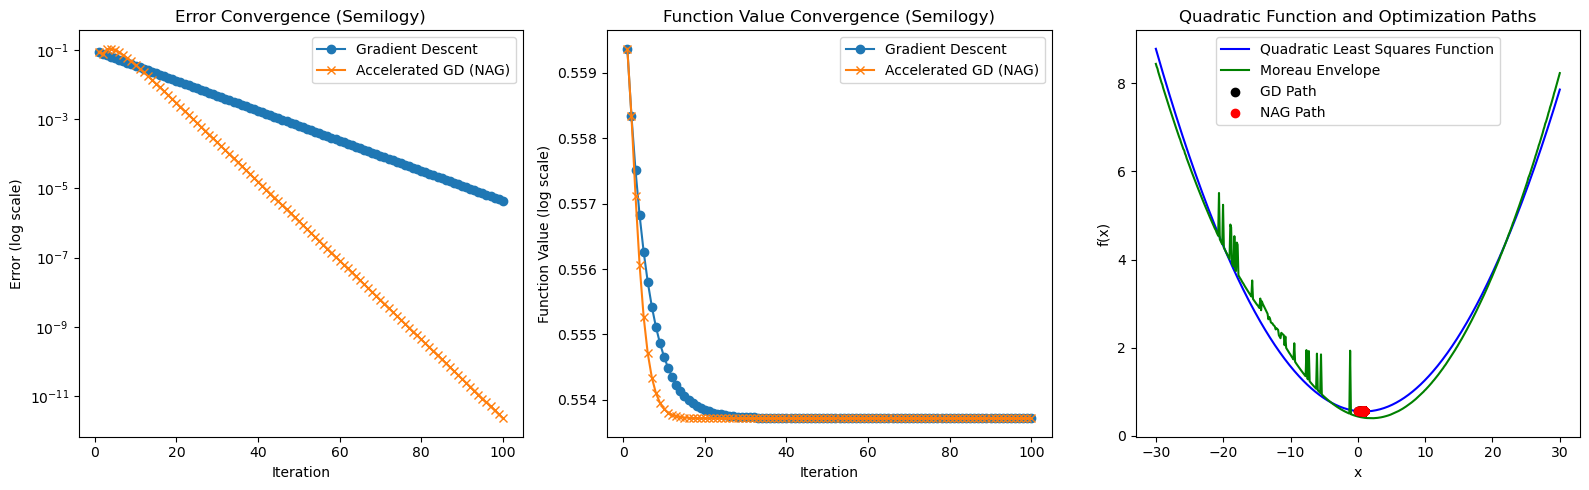

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class QuadraticOptimization:
    def __init__(self, beta, alpha, max_iterations):
        # Conditions from Visualizer
        coeffs = visualizer.fit_quadratic_to_moreau_envelope()
        self.a, self.b, self.c = coeffs
        x_0 = visualizer.x_0_input.value
        self.T  = visualizer.fixed_T_input.value
        self.x_vals = visualizer.x_values
        self.u_vals = visualizer.u_values

        # Adjustable parameters
        self.alpha = alpha
        self.max_iterations = max_iterations
        self.beta = beta

        # Variables for GD and Accelerated GD
        self.k = 0  # iteration counter
        self.x_k = x_0  # for gradient descent
        self.acc_x_k = x_0  # for accelerated gradient descent
        self.acc_x_k_minus_1 = x_0  # previous value for NAG

        # Lists to store function values and errors
        self.gd_errors = []
        self.nag_errors = []
        self.gd_values = []
        self.nag_values = []
        self.gd_points = []  # x values for gradient descent path
        self.nag_points = []  # x values for NAG path
        self.gk_hist = [(self.x_k,self.gradient(self.x_k))]

    def quadratic_function(self, x):
        """Quadratic function f(x) = ax^2 + bx + c."""
        return self.a * x ** 2 + self.b * x + self.c

    def gradient(self, x):
        """Gradient of the quadratic function: f'(x) = 2ax + b."""
        return 2 * self.a * x + self.b

    def gradient_descent(self, x):
        """Performs one step of gradient descent."""
        grad = self.gradient(x)
        return x - self.alpha * self.T * grad

    def run_optimization(self):
        for _ in range(self.max_iterations):
            # Perform standard Gradient Descent
            x_k_plus_1 = self.gradient_descent(self.x_k)
            self.gd_points.append(x_k_plus_1)

            # Store function value and error for GD
            gd_value = self.quadratic_function(x_k_plus_1)
            self.gd_values.append(gd_value)
            self.gd_errors.append(np.abs(x_k_plus_1 - self.x_k))
            
            # Update x_k for next iteration
            self.x_k = x_k_plus_1

            # Perform Accelerated Gradient Descent (NAG)
            if self.k > 1:
                y_k = self.acc_x_k + self.beta * (self.acc_x_k - self.acc_x_k_minus_1)
                acc_x_k_plus_1 = self.gradient_descent(y_k)
            else:
                acc_x_k_plus_1 = x_k_plus_1

            self.nag_points.append(acc_x_k_plus_1)

            # Store function value and error for NAG
            nag_value = self.quadratic_function(acc_x_k_plus_1)
            self.nag_values.append(nag_value)
            self.nag_errors.append(np.abs(acc_x_k_plus_1 - self.acc_x_k))

            # Update accelerated variables for next iteration
            self.acc_x_k_minus_1 = self.acc_x_k
            self.acc_x_k = acc_x_k_plus_1

            # Update iteration counter
            self.gk_hist.append((self.x_k,self.gradient(self.x_k)))
            self.k += 1

    def plot_results(self):
        """Plot error convergence, function value, and the quadratic function."""
        iterations = np.arange(1, self.max_iterations + 1)

        # Plot error convergence using semilogy
        plt.figure(figsize=(16, 5))

        plt.subplot(1, 3, 1)
        plt.semilogy(iterations, self.gd_errors, label='Gradient Descent', marker='o')
        plt.semilogy(iterations, self.nag_errors, label='Accelerated GD (NAG)', marker='x')
        plt.title('Error Convergence (Semilogy)')
        plt.xlabel('Iteration')
        plt.ylabel('Error (log scale)')
        plt.legend()

        # Plot function value using semilogy
        plt.subplot(1, 3, 2)
        plt.plot(iterations, self.gd_values, label='Gradient Descent', marker='o')
        plt.plot(iterations, self.nag_values, label='Accelerated GD (NAG)', marker='x')
        plt.title('Function Value Convergence (Semilogy)')
        plt.xlabel('Iteration')
        plt.ylabel('Function Value (log scale)')
        plt.legend()

        # Plot the quadratic function and the optimization points
        y_vals = self.quadratic_function(self.x_vals)

        plt.subplot(1, 3, 3)
        plt.plot(self.x_vals, y_vals, label='Quadratic Least Squares Function', color='blue')
        plt.plot(self.x_vals, self.u_vals, label='Moreau Envelope', color='green')
        plt.scatter(self.gd_points, [self.quadratic_function(x) for x in self.gd_points], color='black', label='GD Path', zorder=5)
        plt.scatter(self.nag_points, [self.quadratic_function(x) for x in self.nag_points], color='red', label='NAG Path', zorder=5)
        plt.title('Quadratic Function and Optimization Paths')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.legend()

        plt.tight_layout()
        plt.show()


# Example usage with a quadratic function f(x) = 2x^2 - 3x + 1
if __name__ == "__main__":
    alpha = 0.11
    beta = 0.5
    max_iterations = 100

    optimizer = QuadraticOptimization(beta, alpha, max_iterations)
    optimizer.run_optimization()
    optimizer.plot_results()
